In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as Datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.models as models
import torchvision.utils as vutils
from torch.hub import load_state_dict_from_url
import lpips

import os,glob
import random
import numpy as np
import math
from IPython.display import clear_output
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import trange, tqdm

import Helpers as hf
from RES_VAE import VAE as VAE
from vgg19 import VGG19

import preprocess as prep

In [2]:
batch_size = 64
image_size = 128 #QH edited from 64 to 128
lr = 1e-4
nepoch = 100
start_epoch = 0
#dataset_root = "/media/luke/Quick Storage/Data"
#dataset_root = "/scratch/gpfs/qh8777/qhhome/celebA"
save_dir = os.getcwd()
model_name = "CelebFourDim"
load_checkpoint  = True

In [3]:
use_cuda = torch.cuda.is_available()
GPU_indx  = 1
device = torch.device(GPU_indx if use_cuda else "cpu")
device

device(type='cuda', index=1)

In [4]:
#only if not using GPU
device = torch.device("cpu")
device

device(type='cpu')

In [5]:
#%load_ext autoreload
#%autoreload 2
def get_data_CelebA(transform, batch_size, download = True, root = "/data"):
    print("Loading trainset...")
    trainset = Datasets.CelebA(root=root, split='train', transform=transform, download=download)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    print("Loading testset...")
    testset = Datasets.CelebA(root=root, split='test', download=download, transform=transform)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    print("Done!")
    return trainloader, testloader

In [6]:
dataset_root = '/scratch/gpfs/qh8777/qhhome/ATrainingImageSet'
transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.RandomHorizontalFlip(0.5),
                                transforms.ToTensor(),
                                transforms.Normalize(0.5, 0.5)])

trainloader, testloader = get_data_CelebA(transform, batch_size, download=False, root=dataset_root)

Loading trainset...
Loading testset...
Done!


In [7]:
#get a test image batch from the testloader to visualise the reconstruction quality
dataiter = iter(testloader)
test_images, _ = next(dataiter)
test_images.shape

torch.Size([64, 3, 128, 128])

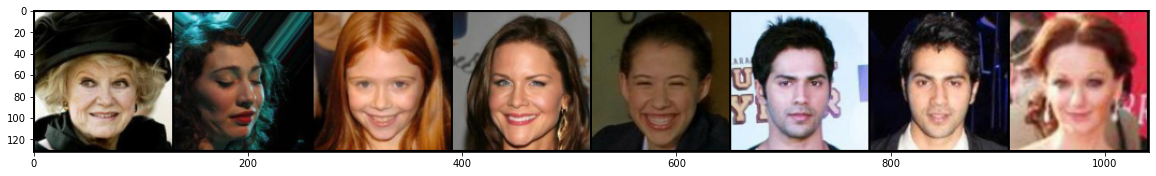

In [8]:
plt.figure(figsize = (20,10))
out = vutils.make_grid(test_images[0:8], normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

In [9]:
# Create the feature loss module
feature_extractor = VGG19().to(device)

In [10]:
#Create VAE network
vae_net = VAE(channel_in=3, ch=64).to(device)
# setup optimizer
optimizer = optim.Adam(vae_net.parameters(), lr=lr, betas=(0.5, 0.999))
#Loss function
loss_log = []

In [11]:
#Create the save directory if it does note exist
if not os.path.isdir(save_dir + "/Models"):
    os.makedirs(save_dir + "/Models")
if not os.path.isdir(save_dir + "/Results"):
    os.makedirs(save_dir + "/Results")

if load_checkpoint:
    checkpoint = torch.load(save_dir + "/Models/" + model_name + "_" + str(image_size) + ".pt", map_location = "cpu")
    print("Checkpoint loaded")
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    vae_net.load_state_dict(checkpoint['model_state_dict'])
    start_epoch = checkpoint["epoch"]
    loss_log = checkpoint["loss_log"]
else:
    #If checkpoint does exist raise an error to prevent accidental overwriting
    if os.path.isfile(save_dir + "/Models/" + model_name + "_" + str(image_size) + ".pt"):
        raise ValueError("Warning Checkpoint exists")
    else:
        print("Starting from scratch")

Checkpoint loaded


In [12]:
#plot loss function (dont run)
'''
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#fig = plt.figure()
fig, ax = plt.subplots(1,2, figsize=(16,8))
for i in range(len(loss_log)):
    #print(train_losses[i][0], train_losses[i][1])
    ax[0].plot(i, loss_log[i], 'bo')
ax[0].set(title = 'training')
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('training loss')


plt.show()
'''

"\nimport matplotlib.pyplot as plt\nimport matplotlib.image as mpimg\n\n#fig = plt.figure()\nfig, ax = plt.subplots(1,2, figsize=(16,8))\nfor i in range(len(loss_log)):\n    #print(train_losses[i][0], train_losses[i][1])\n    ax[0].plot(i, loss_log[i], 'bo')\nax[0].set(title = 'training')\nax[0].set_xlabel('iteration')\nax[0].set_ylabel('training loss')\n\n\nplt.show()\n"

In [13]:
dataiter = iter(trainloader)
images, _ = next(dataiter)
len(dataiter)
images.shape

torch.Size([64, 3, 128, 128])

In [14]:
recon_img, mu, logvar = vae_net(images)
recon_img

tensor([[[[ 7.0806e-02,  2.5569e-02, -1.3087e-01,  ..., -3.7997e-01,
           -5.1483e-01, -4.2703e-01],
          [ 2.5126e-01,  1.8743e-01,  2.7386e-01,  ..., -2.0591e-01,
           -1.7059e-01, -2.4620e-01],
          [-6.6322e-03,  1.3800e-01,  2.0628e-01,  ..., -2.2938e-01,
           -1.9555e-01, -1.3092e-01],
          ...,
          [ 1.1930e-02, -4.2339e-02,  2.5192e-02,  ..., -1.7680e-01,
           -1.4550e-01, -1.5405e-01],
          [ 1.3976e-01,  1.6893e-01,  2.4480e-01,  ..., -1.6667e-02,
            1.3856e-01, -2.0286e-01],
          [ 1.6611e-01, -8.0435e-02, -2.3529e-01,  ..., -9.3012e-02,
           -8.8919e-02, -4.2762e-01]],

         [[ 2.3566e-01,  2.2718e-01,  1.1341e-01,  ...,  1.7548e-02,
           -2.6452e-02, -1.4402e-01],
          [ 2.4210e-01,  1.3868e-01,  1.4370e-01,  ..., -2.6298e-01,
           -1.9245e-01, -2.9471e-01],
          [ 1.6483e-01,  1.1740e-01,  9.6533e-02,  ..., -2.3225e-01,
           -2.3303e-01, -3.0889e-01],
          ...,
     

In [15]:
len(logvar[0]) #mu/logvar dimension: 64x512x5x5
def sample(mu, logvar):
    std = torch.exp(0.5*logvar)  # e^(1/2 * log(std^2))
    eps = torch.randn_like(std)  # random ~ N(0, 1)
    return eps.mul(std).add_(mu)
z = sample(mu,logvar)
sample_img_all = vae_net.decoder(z)
zs = z[0:1]
sample_img = vae_net.decoder(zs)
z.shape,zs.shape

(torch.Size([64, 4, 5, 5]), torch.Size([1, 4, 5, 5]))

In [16]:
#instead of above that finds the latents corresponding to a training image, I randomly generate the latents
size = torch.Size([1, 4, 5, 5])
z_random = torch.randn(size)
z_random.shape

torch.Size([1, 4, 5, 5])

In [17]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torchvision.transforms.functional import crop

def plot_latent(z_temp):

    #im = torch.squeeze(model.decode(z_temp).cpu())
    im = vae_net.decoder(z_temp)
    img = im.detach().numpy().squeeze()
    img_t = np.zeros((img.shape[1], img.shape[2], img.shape[0]))
    img_t[:,:,0] = img[0,:,:].squeeze()
    img_t[:,:,1] = img[1,:,:].squeeze()
    img_t[:,:,2] = img[2,:,:].squeeze()
    img_t =  (img_t - img_t.min()) / (img_t.max() - img_t.min()) #normalize between 0 and 1
    plt.imshow(img_t)

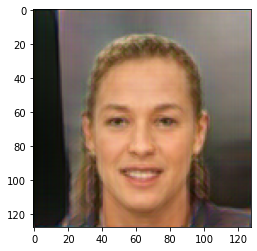

In [18]:
plot_latent(z[17:18])
#plot_latent(z_random) 

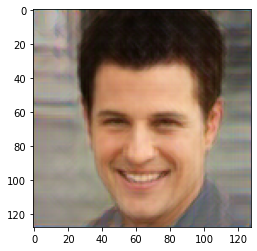

In [24]:
#plot reconstructed image
img = recon_img[0].detach().numpy().squeeze()
img_t = np.zeros((img.shape[1], img.shape[2], img.shape[0]))
img_t[:,:,0] = img[0,:,:].squeeze()
img_t[:,:,1] = img[1,:,:].squeeze()
img_t[:,:,2] = img[2,:,:].squeeze()
img_t =  (img_t - img_t.min()) / (img_t.max() - img_t.min()) #normalize between 0 and 1
plt.imshow(img_t)